In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from tabulate import tabulate
from finance_byu.rolling import roll_sum
from finance_byu.summarize import summary
from finance_byu.regtables import Regtable

# Initiations:

In [73]:
pd.options.display.max_rows = 100

# Read in the monthly CRSP data, clean, and set up features
stk = pd.read_feather('C:/Users/jarem/Downloads/crsp_monthly.ftr')
stk['mdt'] = stk['caldt'].values.astype('datetime64[M]')

stk['prc'] = stk['prc'].abs()
stk['me']  = stk.eval("prc*shr/1000.0").where(stk.eval("prc*shr > 1e-6")) 

stk['prclag'] = stk.groupby('permno')['prc'].shift()
stk['melag'] = stk.groupby('permno')['me'].shift()
stk

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr,mdt,me,prclag,melag
0,10000,1986-01-31,68391610,OMFGA,10,3,3990,4.37500,NaN,1771.0,3680.0,1.0,1986-01-01,1.610000e+01,NaN,NaN
1,10000,1986-02-28,68391610,OMFGA,10,3,3990,3.25000,-0.257143,828.0,3680.0,1.0,1986-02-01,1.196000e+01,4.37500,1.610000e+01
2,10000,1986-03-31,68391610,OMFGA,10,3,3990,4.43750,0.365385,1078.0,3680.0,1.0,1986-03-01,1.633000e+01,3.25000,1.196000e+01
3,10000,1986-04-30,68391610,OMFGA,10,3,3990,4.00000,-0.098592,957.0,3793.0,1.0,1986-04-01,1.517200e+01,4.43750,1.633000e+01
4,10000,1986-05-30,68391610,OMFGA,10,3,3990,3.10938,-0.222656,1074.0,3793.0,1.0,1986-05-01,1.179388e+01,4.00000,1.517200e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5004038,93436,2024-08-30,88160R10,TSLA,11,3,9999,214.11000,-0.077391,16108365.0,3194640.0,1.0,2024-08-01,6.840044e+05,232.07001,7.413801e+05
5004039,93436,2024-09-30,88160R10,TSLA,11,3,9999,261.63000,0.221942,16042065.0,3207000.0,1.0,2024-09-01,8.390474e+05,214.11000,6.840044e+05
5004040,93436,2024-10-31,88160R10,TSLA,11,3,9999,249.85001,-0.045025,19014312.0,3210060.0,1.0,2024-10-01,8.020335e+05,261.63000,8.390474e+05
5004041,93436,2024-11-29,88160R10,TSLA,11,3,9999,345.16000,0.381469,20821313.0,3210060.0,1.0,2024-11-01,1.107984e+06,249.85001,8.020335e+05


In [74]:
# Read in the dividends data, clean, and set up features
div = pd.read_csv('C:/Users/jarem/Downloads/dividends_cash.csv',parse_dates=['paydt'])
div['mdt'] = div['paydt'].values.astype('datetime64[M]')
div = div[['permno','mdt','divamt']]
div

,permno,mdt,divamt
0,10001,1986-03-01,0.095
1,10001,1986-06-01,0.105
2,10001,1986-09-01,0.105
3,10001,1986-12-01,0.105
4,10001,1987-03-01,0.105
...,...,...,...
985382,93429,2023-12-01,0.550
985383,93429,2024-03-01,0.550
985384,93429,2024-06-01,0.550
985385,93429,2024-09-01,0.630


In [75]:
# Merge the data and lag 1 month to avoid counting the current month
stk = stk.merge(div,on=['permno','mdt'],how='left')
stk['div'] = stk['divamt'].notnull().astype(int)
    
stk['d12'] = (stk.groupby('permno')['div'].rolling(12).sum()
                     .reset_index(drop=True) )
stk['d12'] = stk.groupby('permno')['d12'].shift(1)
stk

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr,mdt,me,prclag,melag,divamt,div,d12
0,10000,1986-01-31,68391610,OMFGA,10,3,3990,4.37500,NaN,1771.0,3680.0,1.0,1986-01-01,1.610000e+01,NaN,NaN,NaN,0,NaN
1,10000,1986-02-28,68391610,OMFGA,10,3,3990,3.25000,-0.257143,828.0,3680.0,1.0,1986-02-01,1.196000e+01,4.37500,1.610000e+01,NaN,0,NaN
2,10000,1986-03-31,68391610,OMFGA,10,3,3990,4.43750,0.365385,1078.0,3680.0,1.0,1986-03-01,1.633000e+01,3.25000,1.196000e+01,NaN,0,NaN
3,10000,1986-04-30,68391610,OMFGA,10,3,3990,4.00000,-0.098592,957.0,3793.0,1.0,1986-04-01,1.517200e+01,4.43750,1.633000e+01,NaN,0,NaN
4,10000,1986-05-30,68391610,OMFGA,10,3,3990,3.10938,-0.222656,1074.0,3793.0,1.0,1986-05-01,1.179388e+01,4.00000,1.517200e+01,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5041301,93436,2024-08-30,88160R10,TSLA,11,3,9999,214.11000,-0.077391,16108365.0,3194640.0,1.0,2024-08-01,6.840044e+05,232.07001,7.413801e+05,NaN,0,0.0
5041302,93436,2024-09-30,88160R10,TSLA,11,3,9999,261.63000,0.221942,16042065.0,3207000.0,1.0,2024-09-01,8.390474e+05,214.11000,6.840044e+05,NaN,0,0.0
5041303,93436,2024-10-31,88160R10,TSLA,11,3,9999,249.85001,-0.045025,19014312.0,3210060.0,1.0,2024-10-01,8.020335e+05,261.63000,8.390474e+05,NaN,0,0.0
5041304,93436,2024-11-29,88160R10,TSLA,11,3,9999,345.16000,0.381469,20821313.0,3210060.0,1.0,2024-11-01,1.107984e+06,249.85001,8.020335e+05,NaN,0,0.0


In [76]:
# Calculate any initiations in the last 5 years prior to last year  
stk['div60to13'] = (stk.groupby('permno')['div'].rolling(48,12).sum().reset_index(drop=True))

stk['div60to13'] = stk.groupby('permno')['div60to13'].shift(13)

stk['port'] = stk.eval("d12 > 0 and div60to13 == 0").astype(int) 
    
stk = (stk.query("10 <= shrcd <= 11 and melag == melag and "
                 "prclag > 4.999 and ret == ret").reset_index(drop=True))
stk

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,...,cumfacshr,mdt,me,prclag,melag,divamt,div,d12,div60to13,port
0,10001,1986-02-28,39040610,GFGC,11,3,4920,6.25000,0.020408,1067.0,...,3.0,1986-02-01,6.156250e+00,6.12500,6.033125e+00,NaN,0,NaN,NaN,0
1,10001,1986-03-31,39040610,GFGC,11,3,4920,6.31250,0.025200,335.0,...,3.0,1986-03-01,6.217812e+00,6.25000,6.156250e+00,0.095,1,NaN,NaN,0
2,10001,1986-04-30,39040610,GFGC,11,3,4920,6.37500,0.009901,225.0,...,3.0,1986-04-01,6.279375e+00,6.31250,6.217812e+00,NaN,0,NaN,NaN,0
3,10001,1986-05-30,39040610,GFGC,11,3,4920,6.31250,-0.009804,217.0,...,3.0,1986-05-01,6.217812e+00,6.37500,6.279375e+00,NaN,0,NaN,NaN,0
4,10001,1986-06-30,39040610,GFGC,11,3,4920,6.12500,-0.013069,238.0,...,3.0,1986-06-01,6.033125e+00,6.31250,6.217812e+00,0.105,1,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2888510,93436,2024-08-30,88160R10,TSLA,11,3,9999,214.11000,-0.077391,16108365.0,...,1.0,2024-08-01,6.840044e+05,232.07001,7.413801e+05,NaN,0,0.0,0.0,0
2888511,93436,2024-09-30,88160R10,TSLA,11,3,9999,261.63000,0.221942,16042065.0,...,1.0,2024-09-01,8.390474e+05,214.11000,6.840044e+05,NaN,0,0.0,0.0,0
2888512,93436,2024-10-31,88160R10,TSLA,11,3,9999,249.85001,-0.045025,19014312.0,...,1.0,2024-10-01,8.020335e+05,261.63000,8.390474e+05,NaN,0,0.0,0.0,0
2888513,93436,2024-11-29,88160R10,TSLA,11,3,9999,345.16000,0.381469,20821313.0,...,1.0,2024-11-01,1.107984e+06,249.85001,8.020335e+05,NaN,0,0.0,0.0,0


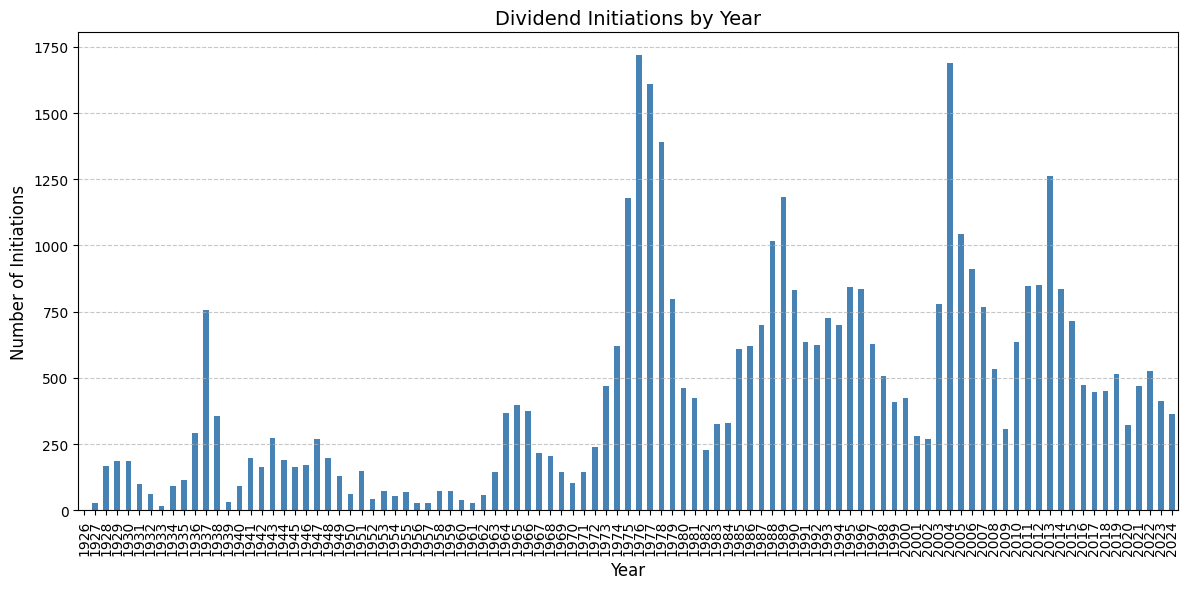

In [77]:
# Count and plot initiations by year to check
init_counts = stk.groupby(stk['caldt'].dt.year)['port'].sum()

plt.figure(figsize=(12, 6))
init_counts.plot(kind='bar', color='steelblue')
plt.title('Dividend Initiations by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Initiations', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [78]:
# Calculate the equal weight portfolios
ew = (stk.groupby(['caldt','port'])['ret'].mean().unstack(level='port')
          .rename('p{:.0f}'.format,axis='columns')*100)    

# Get summary statistics for equal weight and print the results
ew_summ = summary(ew)

print("Equal-Weight Portfolios")
ew_summ.round(3)

Equal-Weight Portfolios


port,p0,p1
count,1188.000,1167.000
mean,1.042,1.632
std,6.337,8.671
tstat,5.667,6.431
pval,0.000,0.000
min,-30.908,-34.871
25%,-1.961,-2.177
50%,1.484,1.786
75%,4.377,5.445
max,44.215,129.667


In [79]:
# Get summary statistics for value weight and print the results
stk['rme'] = stk['ret']*stk['melag']
vw = ((stk.groupby(['caldt','port'])['rme'].sum()/
        stk.groupby(['caldt','port'])['melag'].sum()).unstack(level='port')
        .rename('p{:.0f}'.format,axis='columns')*100)    
vw_summ = summary(vw)
print("Value-Weight Portfolios")
vw_summ.round(3)

Value-Weight Portfolios


port,p0,p1
count,1188.000,1167.000
mean,0.945,1.171
std,5.237,9.485
tstat,6.217,4.217
pval,0.000,0.000
min,-28.770,-45.220
25%,-1.744,-3.046
50%,1.344,1.433
75%,3.943,5.465
max,37.899,129.667


In [80]:
# Now test the model with the CAPM and Fama French models
names = ew.columns.tolist()
    
# Read factors and ensure date parsing
fac = pd.read_csv('C:/Users/jarem/Downloads/14-factors.csv', parse_dates=['caldt'])
fac['caldt'] = fac['caldt'].values.astype('datetime64[M]')  # Match monthly frequency
fac = fac.set_index('caldt')
    
# Ensure ew has a proper datetime index
ew.index = ew.index.values.astype('datetime64[M]')

# Perform the join
ew = ew.join(fac, how='inner')

# Now continue with your analysis
ew[names] = ew[names].sub(ew['rf'], axis=0)
ew['spr'] = ew[names[-1]] - ew['p0']
    
summ = summary(ew[names + ['spr']])        
fm = [smf.ols(f'{y} ~ exmkt + smb + hml + umd', data=ew).fit()
        for y in names + ['spr']]
    
print("Equal-Weight Portfolios")
summ.round(3)

Equal-Weight Portfolios


,p0,p1,spr
count,1173.000,1164.000,1164.000
mean,0.783,1.362,0.588
std,6.367,8.683,5.101
tstat,4.212,5.353,3.934
pval,0.000,0.000,0.000
min,-30.938,-34.901,-22.313
25%,-2.341,-2.476,-1.345
50%,1.245,1.577,0.267
75%,4.163,5.194,2.063
max,44.185,129.647,114.228


In [81]:
# Show the regression results for the models
reg_table = Regtable(fm)
reg_table.render()

,p0,p1,spr
Intercept,-0.038,0.307,0.346
,(-1.38),(1.96),(2.27)
exmkt,0.984,1.119,0.136
,(178.91),(35.36),(4.43)
smb,0.611,0.687,0.076
,(69.78),(13.65),(1.55)
hml,0.135,0.221,0.087
,(16.56),(4.73),(1.91)
umd,-0.013,0.161,0.175
,(-2.07),(4.37),(4.88)


# Omissions

Note the logic here is similar to before, but now all we have to do is perform a count on the number of dividend events in the prior period and if it is bigger than the current period (ex quarterly dividends in the last year should imply that the year should have 4 payouts and if there are only 3 in this year) then there was an omission somewhere 

In [82]:
# Calculate dividend omissions
# A company is considered to have omitted dividends if it had dividends in the past year but not in the current year
stk['div_prev12'] = (stk.groupby('permno')['div'].rolling(12).sum()
                      .reset_index(drop=True))
stk['div_prev12'] = stk.groupby('permno')['div_prev12'].shift(1)

# Create omission flag (had dividends in past year but none in current year)
stk['omit'] = stk.eval("div_prev12 > 0 and d12 == 0").astype(int)

# Filter data as before
stk = (stk.query("10 <= shrcd <= 11 and melag == melag and "
                 "prclag > 4.999 and ret == ret").reset_index(drop=True))

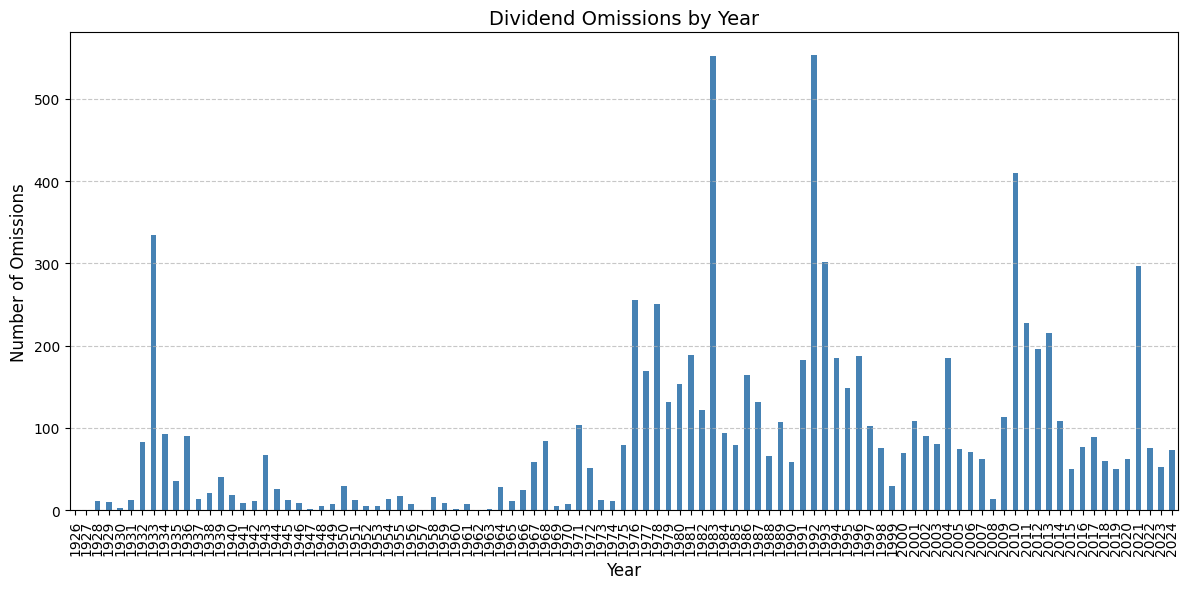

In [83]:
# Count and plot omissions by year to check
omit_counts = stk.groupby(stk['caldt'].dt.year)['omit'].sum()

plt.figure(figsize=(12, 6))
omit_counts.plot(kind='bar', color='steelblue')
plt.title('Dividend Omissions by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Omissions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [84]:
# Equal-weight portfolios for omissions
ew_omit = (stk.groupby(['caldt','omit'])['ret'].mean().unstack(level='omit')
          .rename('p{:.0f}'.format,axis='columns')*100)

# Print summary statistics
print("\nEqual-Weight Omission Portfolios")
summary(ew_omit).round(3)


Equal-Weight Omission Portfolios


omit,p0,p1
count,1188.000,941.000
mean,1.049,1.099
std,6.330,11.178
tstat,5.714,3.015
pval,0.000,0.003
min,-30.949,-34.426
25%,-1.991,-5.338
50%,1.490,0.623
75%,4.381,6.606
max,43.835,73.750


In [85]:
# Value-weight portfolios for omissions
stk['rme'] = stk['ret']*stk['melag']
vw_omit = ((stk.groupby(['caldt','omit'])['rme'].sum()/
            stk.groupby(['caldt','omit'])['melag'].sum()).unstack(level='omit')
            .rename('p{:.0f}'.format,axis='columns')*100)

print("\nValue-Weight Omission Portfolios")
summary(vw_omit).round(3)


Value-Weight Omission Portfolios


omit,p0,p1
count,1188.000,941.000
mean,0.944,0.947
std,5.242,12.656
tstat,6.206,2.295
pval,0.000,0.022
min,-28.936,-46.183
25%,-1.760,-6.667
50%,1.338,0.000
75%,3.941,7.718
max,37.740,68.489


In [86]:
# Factor model analysis for omissions
ew_omit.index = ew_omit.index.values.astype('datetime64[M]')
ew_omit = ew_omit.join(fac, how='inner')
ew_omit[['p0','p1']] = ew_omit[['p0','p1']].sub(ew_omit['rf'], axis=0)
ew_omit['spr'] = ew_omit['p1'] - ew_omit['p0']

# Run factor regressions
fm_omit = [smf.ols(f'{y} ~ exmkt + smb + hml + umd', data=ew_omit).fit()
          for y in ['p0','p1','spr']]

# Show results
print("\nOmission Portfolios Factor Model Results")
Regtable(fm_omit).render()


Omission Portfolios Factor Model Results


,p0,p1,spr
Intercept,-0.028,-0.619,-0.609
,(-1.00),(-2.32),(-2.30)
exmkt,0.985,1.103,0.141
,(174.76),(19.66),(2.53)
smb,0.606,1.076,0.460
,(67.60),(12.77),(5.49)
hml,0.130,0.542,0.405
,(15.59),(7.05),(5.30)
umd,-0.013,0.032,0.035
,(-2.04),(0.51),(0.56)


# Extentions

We should just extend this by testing out of sample, but also note that because we have done this with tradable securities and not just buy and hold this is already an extention inherently, but to extend further, we should do more out of sample past when they finished testing to.

In [88]:
# For extensions, we can test in different subperiods

# Split sample into early and late periods
split_date = '2005-01-01'
early = stk[stk['caldt'] < split_date]
late = stk[stk['caldt'] >= split_date]

# Repeat analysis for each subperiod
def analyze_subperiod(data, name):
    # Initiation analysis
    ew_init = (data.groupby(['caldt','port'])['ret'].mean().unstack()*100)
    # Omission analysis
    ew_omit = (data.groupby(['caldt','omit'])['ret'].mean().unstack()*100)
    
    print(f"\n{name} Period Results")
    print("Initiations:")
    print(summary(ew_init).round(3))
    print("\nOmissions:")
    print(summary(ew_omit).round(3))

analyze_subperiod(early, "Early")
analyze_subperiod(late, "Late")


Early Period Results
Initiations:
port         0        1
count  948.000  927.000
mean     1.111    1.812
std      6.559    9.231
tstat    5.214    5.976
pval     0.000    0.000
min    -30.908  -34.871
25%     -1.949   -2.092
50%      1.580    1.902
75%      4.454    5.856
max     44.215  129.667

Omissions:
omit         0        1
count  948.000  708.000
mean     1.120    1.254
std      6.552   11.445
tstat    5.261    2.915
pval     0.000    0.004
min    -30.949  -32.774
25%     -1.958   -5.363
50%      1.567    0.698
75%      4.438    6.674
max     43.835   73.750

Late Period Results
Initiations:
port         0        1
count  240.000  240.000
mean     0.770    0.940
std      5.374    6.007
tstat    2.220    2.425
pval     0.027    0.016
min    -21.524  -29.002
25%     -2.016   -2.644
50%      1.205    1.677
75%      4.059    4.251
max     17.958   26.039

Omissions:
omit         0        1
count  240.000  233.000
mean     0.773    0.627
std      5.372   10.331
tstat    2.228    0